In [23]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

exp_ensemble


In [24]:
oof_df = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_df.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.004654,0.000332
1,05e1944c3818,18,0.003008,0.000308
2,05e1944c3818,30,0.002308,0.000296
3,05e1944c3818,42,0.001987,0.000282
4,05e1944c3818,54,0.001864,0.000265


In [25]:
dfs = []
for sid, df in tqdm(oof_df.groupby("series_id")):
    step_df = pd.read_parquet(f"{CFG['dataset']['step_csv_dir']}/{sid}.parquet")
    df = df.merge(step_df[["step", "day", "wakeup_target", "onset_target"]], on="step", how="right")

    day_df = pd.concat([
        df.groupby("day")[["wakeup_oof", "onset_oof"]].max(),
        (df.groupby("day")["wakeup_target"].max() > 0).rename("have_target"),
    ], axis=1)
    dfs.append(day_df)

100%|██████████| 277/277 [00:40<00:00,  6.76it/s]


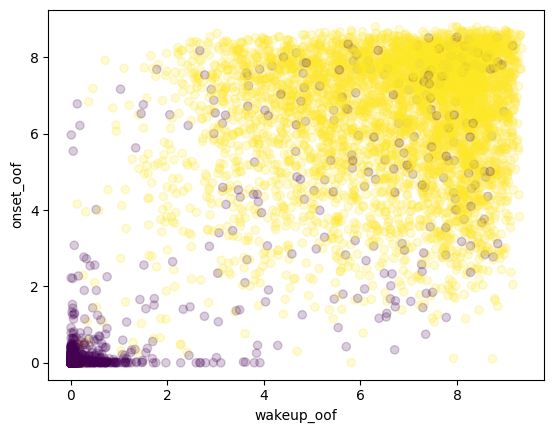

In [26]:
import matplotlib.pyplot as plt

df = pd.concat(dfs).reset_index()
plt.scatter(df["wakeup_oof"], df["onset_oof"], alpha=0.2, c=df["have_target"])
plt.xlabel("wakeup_oof")
plt.ylabel("onset_oof")
plt.show()

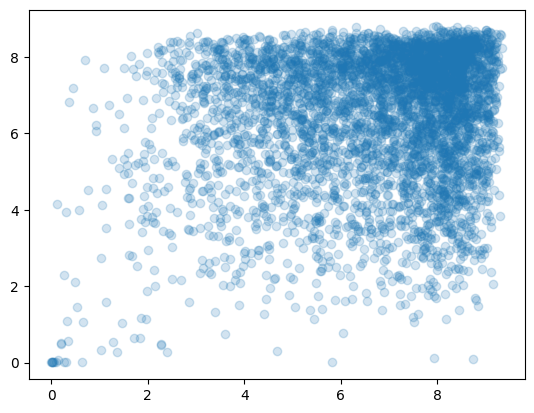

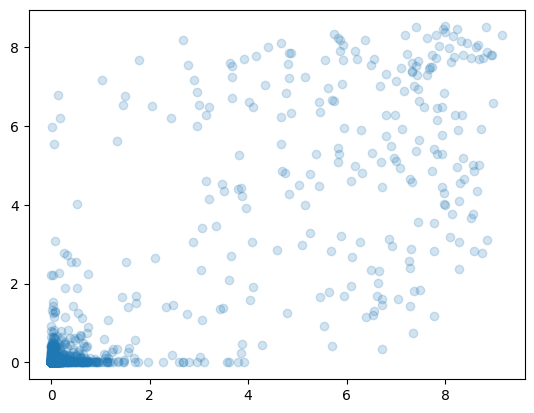

In [27]:
plt.scatter(df[df["have_target"]]["wakeup_oof"], df[df["have_target"]]["onset_oof"], alpha=0.2)
plt.show()
plt.scatter(df[~df["have_target"]]["wakeup_oof"], df[~df["have_target"]]["onset_oof"], alpha=0.2)
plt.show()

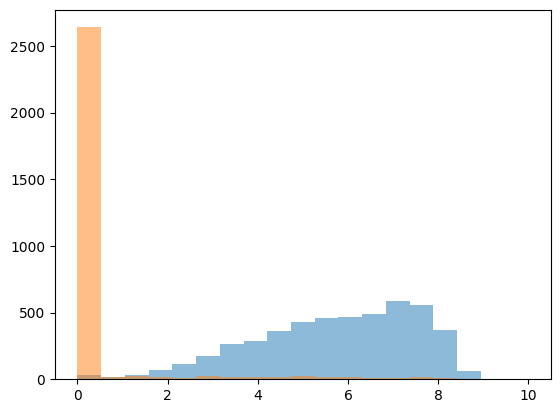

In [28]:
import numpy as np

df["pred_sum"] = df[["wakeup_oof", "onset_oof"]].min(axis=1)
plt.hist(df[df["have_target"]]["pred_sum"], bins=np.linspace(0, 10, 20), alpha=0.5)
plt.hist(df[~df["have_target"]]["pred_sum"], bins=np.linspace(0, 10, 20), alpha=0.5) 
plt.show()

---

In [29]:
threshold = 0.25

dfs = []
for sid, df in tqdm(oof_df.groupby("series_id")):
    step_df = pd.read_parquet(f"{CFG['dataset']['step_csv_dir']}/{sid}.parquet")
    df = df.merge(step_df[["step", "day"]], on="step", how="right")
    
    pred_sum = df.groupby("day")[["wakeup_oof", "onset_oof"]].max().min(axis=1)
    df["pred_sum"] = df["day"].map(pred_sum)
    df = df[df["pred_sum"] > threshold]
    dfs.append(df)
oof_df = pd.concat(dfs).reset_index(drop=True)

100%|██████████| 277/277 [00:41<00:00,  6.71it/s]


2722836

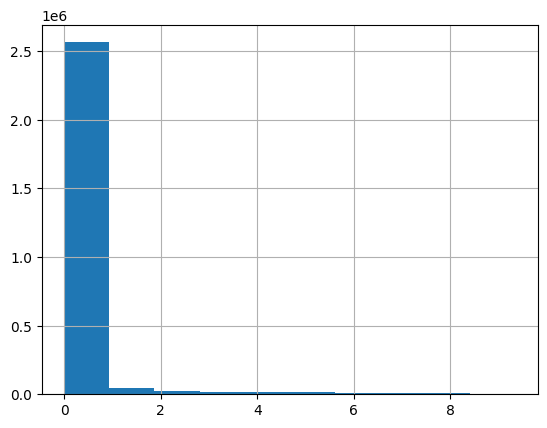

In [30]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.001]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.001]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["step"] = train["step"].astype(int)
train["score"].hist()
len(train)

In [31]:
from multiprocessing import Pool

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 270/270 [00:07<00:00, 35.61it/s]


In [32]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.8068


event   tolerance
onset   12           0.409207
        36           0.720414
        60           0.793641
        90           0.830894
        120          0.857609
        150          0.868121
        180          0.881418
        240          0.892325
        300          0.898822
        360          0.905459
wakeup  12           0.442037
        36           0.726713
        60           0.800008
        90           0.825532
        120          0.849721
        150          0.861116
        180          0.874120
        240          0.888614
        300          0.900776
        360          0.909109
dtype: float64

---